## Imports

In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

## Cargamos los datos

In [45]:
df = pd.read_csv("../data/processed/df_betania.csv")
df.shape


(158279, 22)

In [46]:
df.head(3)

,Race,Primary Site,Combined Summary Stage with Expanded Regional Codes (2004+),vital_status,Radiation recode,"Chemotherapy recode (yes, no/unk)",Sex,Rural Code,Reason no cancer-directed surgery,Total number of in situ/malignant tumors for patient,...,age_group,income_level,target_cancer_death,survival_months_int,survival_range,histology_type_named,tumor_category,Stage_Final,grade_clinical,tratamiento
0,White,"C34.1-Upper lobe, lung",Regional by both direct extension and lymph no...,Alive,None/Unknown,Yes,Male,Counties in metropolitan areas ge 1 million pop,Surgery performed,2,...,4,5,0,59,60,Adenocarcinoma,70,1,2,S + Q + UN
1,White,"C34.1-Upper lobe, lung",Regional by direct extension only,dead,None/Unknown,No/Unknown,Female,Counties in metropolitan areas ge 1 million pop,Surgery performed,2,...,5,4,1,52,54,Adenocarcinoma,30,2,3,S + nQ + UN
2,White,"C34.1-Upper lobe, lung",Localized only,Alive,None/Unknown,No/Unknown,Female,Counties in metropolitan areas ge 1 million pop,Not recommended,3,...,4,5,0,12,12,Adenocarcinoma,50,1,3,N + nQ + UN


In [47]:
df["Reason no cancer-directed surgery"].unique()

array(['Surgery performed', 'Not recommended', 'Refused'], dtype=object)

In [48]:
df.drop(columns=['Race','Sex', 'Combined Summary Stage with Expanded Regional Codes (2004+)'], inplace=True)  


In [63]:
NUM_FEATURES = [
    "age_group",
    "tumor_category",
    "grade_clinical",
    "Total number of in situ/malignant tumors for patient",
]

CAT_FEATURES = [
    "tratamiento",
    "Primary Site",
    "Stage_Final",
    "histology_type_named",
]

random_state = 42
cortes = [12, 24, 36, 48, 60]
idx = 0  # 0->12, 1->24, 2->36, 3->48, 4->60
MES = cortes[idx]

In [64]:
needed = set(NUM_FEATURES + CAT_FEATURES + ["target_cancer_death", "survival_months_int"])
missing = sorted(list(needed - set(df.columns)))
if missing:
    raise ValueError(f"Faltan columnas en df: {missing}")
print("OK - columnas necesarias presentes.")

OK - columnas necesarias presentes.


ENTRENAMIENTO CON FILTRO DINÁMICO POR HITO

In [65]:
def build_hito_dataset(df: pd.DataFrame, meses: int) -> tuple[pd.DataFrame, str]:
    condicion_muerte = (df["target_cancer_death"] == 1)
    condicion_vivo_suficiente = (df["target_cancer_death"] == 0) & (df["survival_months_int"] >= meses)

    df_hito = df[condicion_muerte | condicion_vivo_suficiente].copy()

    target_col = f"target_{meses}_m"
    df_hito[target_col] = np.where(
        (df_hito["target_cancer_death"] == 1) & (df_hito["survival_months_int"] <= meses),
        1,
        0,
    )
    return df_hito, target_col

## Definimos X e y

In [66]:
X = df_hito[NUM_FEATURES + CAT_FEATURES]
y = df_hito[target_col]

## Split 80/20

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [68]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), NUM_FEATURES),
        ("cat", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"), CAT_FEATURES),
    ]
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(
            n_estimators=120,
            learning_rate=0.1,
            max_depth=5,
            subsample=0.8,
            random_state=random_state,
        )),
    ]
)

pipeline.fit(X_train, y_train)
print("Modelo entrenado.")

Modelo entrenado.


In [69]:
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("AUC:", auc)
print(report)
cm

AUC: 0.9073130593243519
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      7422
           1       0.88      0.88      0.88     15111

    accuracy                           0.84     22533
   macro avg       0.82      0.82      0.82     22533
weighted avg       0.84      0.84      0.84     22533



array([[ 5677,  1745],
       [ 1838, 13273]])

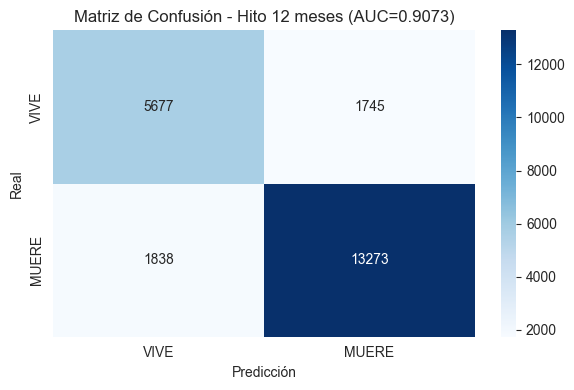

In [74]:
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["VIVE", "MUERE"],
    yticklabels=["VIVE", "MUERE"],
)
plt.title(f"Matriz de Confusión - Hito {MES} meses (AUC={auc:.4f})")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

In [75]:
joblib.dump(pipeline, f"pipeline_{MES}m.pkl")
print("Guardado:", f"pipeline_{MES}m.pkl")

Guardado: pipeline_12m.pkl


Conclusiones (Hito {MES} meses)

- Tamaño del dataset de hito: **{df_hito.shape[0]}** filas.
- Balance del target: (pegar conteo de y aquí).
- Métrica principal (AUC): **{auc:.4f}**.
- Observación: si AUC es muy alto/bajo, revisar:
  - definición del target por hito,
  - leakage (variables que “miran” el futuro),
  - balance de clases,
  - categorías raras en OneHot (handle_unknown).

In [ ]:
# 1. Definir las combinaciones de tratamiento
combinaciones_trat = df["tratamiento"].unique()

# 2. Datos base del paciente (sin el tratamiento)
paciente_base = {
    'age_group': 6,
    'tumor_category': 10.0, 
    'grade_clinical': 1,
    'income_level': 5,
    'Total number of in situ/malignant tumors for patient': 3,
    'Primary Site': 'C34.3-Lower lobe, lung',
    'Stage_Final': 2}

paciente_base = df.iloc[7]
cortes_grafico = [0, 12, 24, 36, 48, 60]
cortes_modelos = [12, 24, 36, 48, 60]

#2. Cargar modelos
modelos = {m: joblib.load(f'pipeline_{m}m.pkl') for m in cortes_modelos}

# 3. Crear la figura (2 filas, 4 columnas)
fig, axes = plt.subplots(4, 5, figsize=(20, 10), sharey=True)
axes = axes.flatten()

for i, trat in enumerate(combinaciones_trat):
    datos_escenario = paciente_base.copy()
    datos_escenario['tratamiento'] = trat
    df_escenario = pd.DataFrame([datos_escenario])
    
    # Iniciamos con 1.0 (100%) para el mes 0
    supervivencia = [1.0]
    ultimo_riesgo = 0.0 # El riesgo empieza en 0
    
    for m in cortes_modelos:
        # Predicción del modelo para el hito m
        p = modelos[m].predict_proba(df_escenario)[0][1]
        
        # CORRECCIÓN MONÓTONA: El riesgo no puede bajar respecto al mes anterior
        if p < ultimo_riesgo:
            p = ultimo_riesgo
        
        supervivencia.append(1 - p)
        ultimo_riesgo = p # Actualizamos para el siguiente mes
    
    # Graficar
    ax = axes[i]
    ax.plot(cortes_grafico, supervivencia, marker='o', linewidth=2.5, color='darkblue', label='Supervivencia')
    ax.fill_between(cortes_grafico, supervivencia, color='skyblue', alpha=0.3)
    
    # Estética y Ejes
    ax.set_title(f"Tratamiento:\n{trat}", fontsize=11, fontweight='bold')
    ax.set_xticks(cortes_grafico) # Forzamos que se vean los meses 0, 12, 24...
    ax.set_ylim(0, 1.05)
    ax.grid(True, linestyle='--', alpha=0.5)
    
    if i >= 4: ax.set_xlabel("Meses post-diagnóstico")
    if i % 4 == 0: ax.set_ylabel("Prob. Supervivencia")

plt.tight_layout()
plt.suptitle("Curvas de Supervivencia Estimadas: Análisis de Escenarios Terapéuticos", 
             fontsize=16, y=1.02, fontweight='bold')
plt.show()

In [15]:
df.iloc[7]

Primary Site                                                                     C34.1-Upper lobe, lung
vital_status                                                                                      Alive
Radiation recode                                                                        Refused (1988+)
Chemotherapy recode (yes, no/unk)                                                            No/Unknown
Rural Code                                              Counties in metropolitan areas ge 1 million pop
Reason no cancer-directed surgery                                                     Surgery performed
Total number of in situ/malignant tumors for patient                                                  2
Sequence number                                                              2nd of 2 or more primaries
Type of Reporting Source                                        Hospital inpatient/outpatient or clinic
age_group                                                       